### CUNY Data 620 - Web Analytics, Summer 2020
**Group Project 1**  
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout  

### Instructions
1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

### Dataset
* **Source**: [Hollywood Film Music Dataset](http://networkdata.ics.uci.edu/netdata/html/movies.html)
* **Format**: The network was stored as an .RData file. We converted the file components to individual text files, creating lists for all composers, producers, and the interaction matrix. We then loaded these text files into jupyter and created a bipartite graph. 
* **Description**: This is a 2-mode network that contains the collaboration of 40 composers of film scores and the 62 producers who produced a minimum of five movies in Hollywood, 1964-1976. A line between a composer and a producer indicates that the former created the soundtrack for the movie produced by the latter. The line values indicate the number of movies by one producer for which the composer created the music in the period 1964- 1976.
* **Nodes**: Each node corresponds to either a composer or producer.  
* **Edges**: Each edge is assigned one weight -- the number of films collaborated on together.

### Motivation
We aim to do the following:  

1) Load the graph as a bipartite network and clearly identify the nodes and edges associated with composers and producers.  

2) Use the "Island Method" outlined in our book, "Social Network Analysis for Startups" to subset our larger graph into a smaller one based on our edge attribute. We'll utilize the edge weight (# of films collaborated on together), to reduce our network to only bipartite relationships between composers and producers that collaborated on at least 2 films together.  

3) We will then make inferences about each of the ego networks that result from this subsetting method. Particularly, we'd like to answer (1) whether or not certain ego networks show higher productivity (productivity = # of films collaborated on together) than others. (2) whether or not there are differences in the clustering coefficient of these ego networks -- essentially showing us the proportion of composer-producer collaborations that also collaborate with each other. 

This will help us answer: Do certain collaborations work in isolation? Or, do most collaborate with the broader network?  

### Importing packages

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spy
import numpy as np
import statistics
from networkx.algorithms import bipartite
from networkx.algorithms import traversal

### Loading in the text files

Since the data could only be downloaded as an .RData file, we first loaded the file into R, isolated the node and edge components, and exported them as text files. With these text files saved in our working directory, we then opened them in our Jupyter notebook and saved the producers and composers (nodes) to lists. Additionally, we loaded in our interaction matrix and also saved this to a list. Finally, in order for us to generate our bipartite graph, we decided to convert these lists to strings for later use.

In [2]:
composerFile = "data/composers.txt"

composers = []
composerfile = open(composerFile, 'r') 
for line in composerfile.readlines(): 
    for element in line[0:-1].split('\t'):
        composers.append(element)
composers = [item for item in composers if composers not in ['\n', '']]
composers = [string for string in composers if string != ""]

In [3]:
producerFile = "data/producers.txt"

producers = []
producerfile = open(producerFile, 'r') 
for line in producerfile.readlines(): 
    for element in line[0:-1].split('\t'):
        producers.append(element)
producers = [item for item in producers if producers not in ['\n', ',']]
producers = [string for string in producers if string != ""]

In [4]:
interaction_matrix = "data/matrix.txt"

interaction_mat = []
interactfile = open(interaction_matrix, 'r') 
for line in interactfile.readlines(): 
    for element in line[0:-1].split('\n'):
        interaction_mat.append(element)
interaction_mat = [item for item in interaction_mat if interaction_mat not in ['\n', '']]
interaction_mat = [string for string in interaction_mat if string != ""]

In [5]:
producers = "\n".join(producers)
composers = "\n".join(composers)
interaction_mat = "\n".join(interaction_mat)

### Constructing the bipartite network
With our separate components loaded in as strings, we then were able to utlize these in our function below to generate our bipartite graph. By setting up an empty graph with the size based on the number of composers (40) and producers (62), we then were able to create separate lists for our two composer/producer components, load in our interaction matrix, and connect our nodes to our edges. Since the interaction matrix had values from 1-7 (indicating the # of collaborations on films between a composer/producer duo), we were able to assign an edge weight based on this value.

In [6]:
def hollywood_graph(create_using=None, **kwds):
    composers_num=40
    producers_num=62
    g=nx.generators.empty_graph(composers_num+producers_num,create_using=create_using,**kwds)
    g.clear()
    g.name="Hollywood Film Music"
    
    # loading the women's names
    producers_list=producers

    # loading the club names
    composers_list=composers

    # loading the interaction matrix
    interaction_matrix=interaction_mat
    
    # creating a list of women names
    c={}
    n=0
    for name in composers_list.split('\n'):
        c[n]=name
        n+=1

    # creating a list of club names
    p={}
    n=0
    for name in producers_list.split('\n'):
        p[n]=name
        n+=1
        
    # parsing our interactions matrix, adding edges
    row=0
    for line in interaction_matrix.split('\n'):
        thisrow=list(map(int,line.split()))
        for col in range(0,len(thisrow)):
            if thisrow[col]>0:
                g.add_edge(p[row],c[col], weight=thisrow[col])
        row+=1
    return (g, list(p.values()),list(c.values()))

In [7]:
(g, producers, composers)=hollywood_graph()

### Network characteristics

After running our function to generate our bipartite graph, we can see below that the network has 101 nodes and 192 edges. The average degree of the network is about 4, which indicates that many composers and producers tend to be less connected to one another (in comparison to a social media network).

In [8]:
print(nx.info(g))

Name: Hollywood Film Music
Type: Graph
Number of nodes: 101
Number of edges: 192
Average degree:   3.8020


In [9]:
nx.is_bipartite(g)

True

After checking to ensure our graph is bipartite in structure, we can also make sure that our edges have a weight attribute assigned. We can see below in an example of one of our edges between a composer and producer that this is indeed true.

In [10]:
g.edges[('Rosenberg, A.', 'Goldsmith, J.')]

{'weight': 3}

### An initial look at our bipartite network

With the structure ready, we can assign colors to both our composers and producers in order to distinguish between different nodes when we generate some graph visualizations. By adding a node attribute of 1 to producers, and a 0 to composers, we can then iterate through our nodes and append a color attribute to each node.

In [11]:
c = bipartite.color(g)
nx.set_node_attributes(g, c, 'bipartite')

In [12]:
def color_nodes(graph, node_list):
    for n in graph.nodes:
        if graph.nodes[str(n)]['bipartite'] == 1:
            node_list.append('lightblue')
        else:
            node_list.append('lightcoral')

In [13]:
comp_prod = []
color_nodes(g, comp_prod)

Next, we can display our bipartite graph in a circular layout, showing connections between composers and producers.

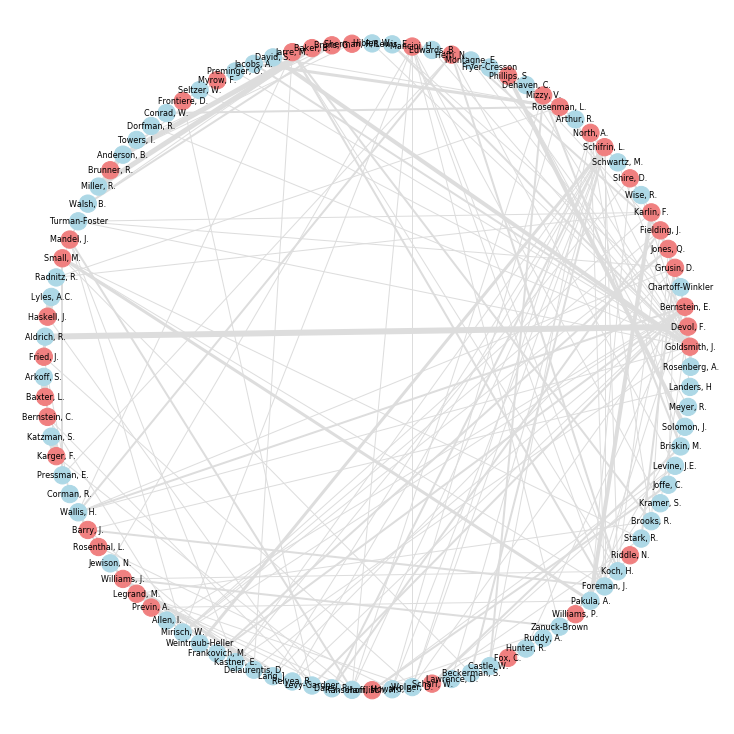

In [30]:
plt.rcParams['figure.figsize'] = [10, 10]
weights = []
weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
nx.draw_circular(g, with_labels='true', node_color=comp_prod, edge_color="#dddddd", font_size=8, width = weights)

We can already start to see that some composers have broader networks than others, and collaborate with a larger number of producers. However, we can continue to run more visualizations and some analysis to make more concrete conclusions.

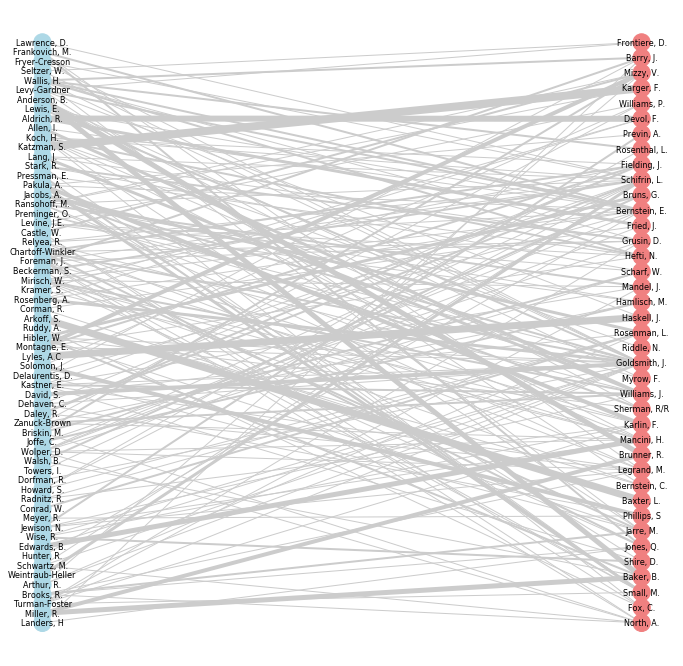

In [15]:
top = nx.bipartite.sets(g)[0]
pos = nx.bipartite_layout(g,top)
plt.rcParams['figure.figsize'] = [12, 12]
plt.axis('off')
nx.draw_networkx(g,pos, node_color=comp_prod, edgecolor='#bbbbbb', edge_color="#cccccc", font_size=8, width = weights)

### Using the Island Method to further subset our network

With some initial observations of our network, we can quickly see that there are a lot of one-off interactions between composers and producers, and this provides a good opportunity for us to further subset our data to hone in on certain ego networks that have arisen in our broader network. Before doing so, we needed to rework the weight value to ensure we could conduct the "Island Method" properly.

In [16]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        key, val = next(iter(edata.items()))
                        g2.add_edge(f,to,weight = val)
        return g2

With the weights trimmed, we can now iterate through our edge attributes and define the various levels of interactions between composers and producers. We define the minimum edge weight at 1 and the maximum edge weight at 7. We assign a step = 1 for our iterations, to show the islands created by adding an additional step in our edge weights. Then, we iterate through our edges, and identify the number of nodes remaining if a certain threshold in our edge weight is reached. For example, we can see that if we removed all one-off interactions between composers and producers in the network, we would see that 71 nodes would be remaining across 15 different islands.

In [17]:
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [18]:
islands=island_method(g)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0], len(i[1]), nx.number_connected_components(i[1]))

1 71 15
2 34 14
3 22 10
4 14 6
5 8 4
6 6 3
7 2 1


After looking at our thresholds, we thought it would be best to progress with the subsetted network that has at least two collaborations on films between a composer/producer duo, which separated our nodes into 15 different islands. The reason for this is due to looking at the next threshold value of at least three collaborations, we would still have our nodes subsetted across 14 islands, not adding much value.

In [19]:
islands

[[1, <networkx.classes.graph.Graph at 0x2d2ca34f8c8>],
 [2, <networkx.classes.graph.Graph at 0x2d2ca34f948>],
 [3, <networkx.classes.graph.Graph at 0x2d2cacb7d08>],
 [4, <networkx.classes.graph.Graph at 0x2d2cacb7408>],
 [5, <networkx.classes.graph.Graph at 0x2d2cacb79c8>],
 [6, <networkx.classes.graph.Graph at 0x2d2cacb7b48>],
 [7, <networkx.classes.graph.Graph at 0x2d2caca0588>]]

By generating our new graph object, we can now assign colors to our composer and producer nodes and redraw our graph, highlighting the 15 distinct islands of nodes.

In [20]:
temp = islands[0]
G = temp[1]
cc = bipartite.color(G)
nx.set_node_attributes(G, cc, 'bipartite')

In [21]:
comp_prod_col = []
color_nodes(G, comp_prod_col)

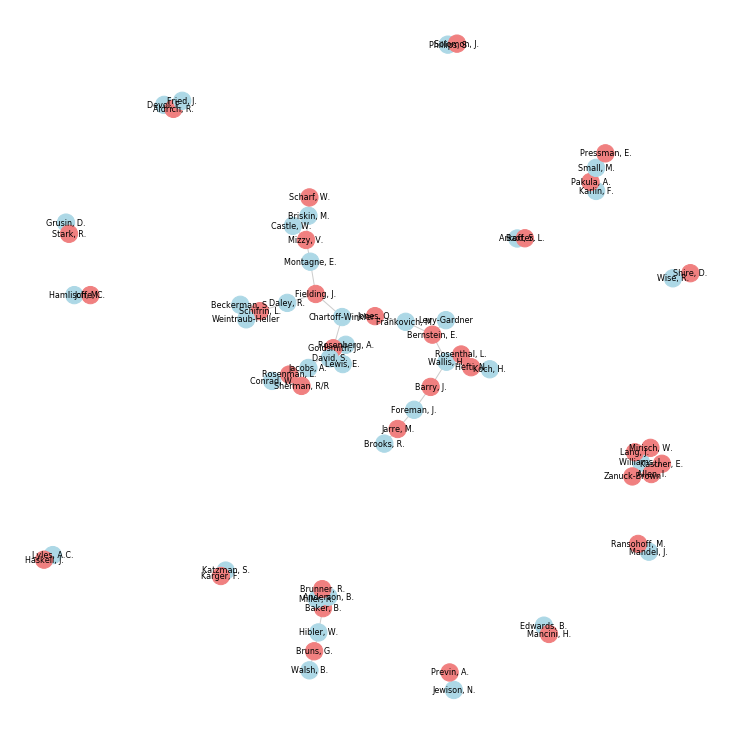

In [22]:
plt.rcParams['figure.figsize'] = [10, 10]
nx.draw(G, with_labels='true', node_color=comp_prod_col, font_size=8, edge_color='#cccccc')

### Inferences about the distinct groups

Now that our graph has been subsetted into multiple islands, we thought it would be interesting to disect the relationships and ego networks that comprise of these groups.

##### Measuring the number of connections of egonets -- radius of 2

Similar to what is outlined in our textbook, we first wanted to traverse our nodes from the perspective of our producers. Therefore, we wrote a function to traverse our nodes, starting at each producer node, and measured the number of nodes that make up a producer's immediate network with a radius equal to two.

In [23]:
reach = []
full_names = producers + composers

for i in full_names:
    if i in G.nodes:
        reach.append((i, len(nx.Graph(nx.ego_graph(G, i, radius=2)))))
    else:
        pass

Then, we created a dataframe of these values to see how many nodes make up each producer's immediate network, and sorted to show the top 4 producers with the most connections. As we can see, Chartoff-Winkler, Wallis, Jacobs, and Montagne make up our list. This isn't much of a surprise given their position in our network visualization above -- all very central nodes, displaying connections to many other composers in the network.

In [35]:
name = []
size = []

for i in reach:
    name.append(i[0])
    size.append(i[1])
    
network_df = pd.DataFrame({'Name': name, 'Network Size (rad=2)': size})
network_df.sort_values(by=['Network Size (rad=2)'], ascending=False).head(4).style.hide_index()

Name,Network Size (rad=2)
Chartoff-Winkler,11
"Goldsmith, J.",10
"Wallis, H.",9
"Jacobs, A.",9


We also displayed this visually, in our bipartite layout below, showing the connections between each of our top 4 producers/composers, and how connected they are to other composers and producers in the network.

In [25]:
def draw_egonet(network_list, i):
    subgraph = nx.Graph(nx.ego_graph(G, network_list[i], radius=2))
    return subgraph

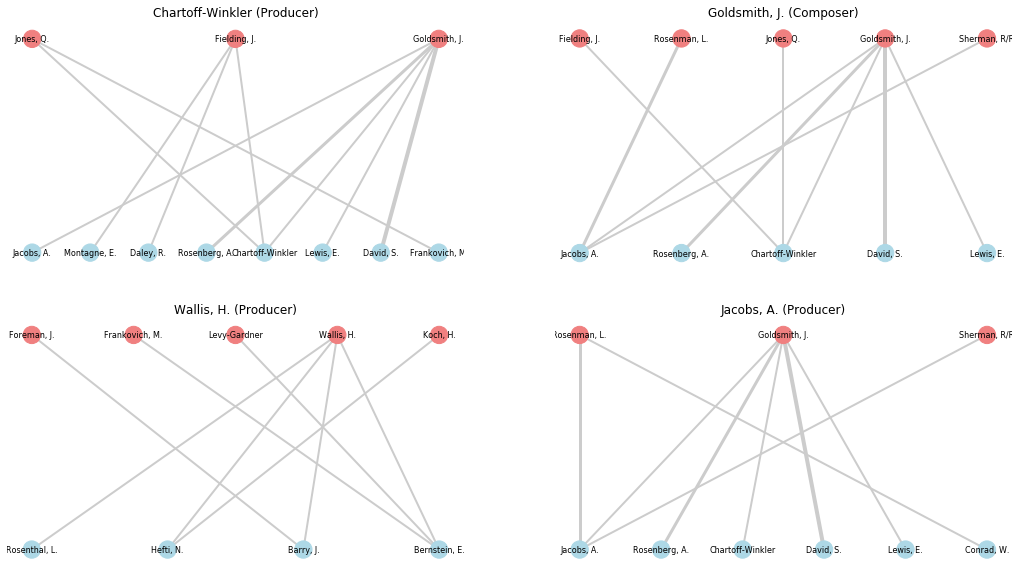

In [33]:
df_for_viz = network_df.sort_values(by=['Network Size (rad=2)'], ascending=False)


for i in range(1, 5):
    col_bipart = []
    weights = []
    subgraph = draw_egonet(list(df_for_viz['Name']), i-1)
    weights= [edata['weight'] for f,to,edata in subgraph.edges(data=True)]
    col = bipartite.color(subgraph)
    nx.set_node_attributes(subgraph, col, 'bipartite')
    color_nodes(subgraph, col_bipart)
    top = nx.bipartite.sets(subgraph)[1]
    pos = nx.bipartite_layout(subgraph,top, align='horizontal')
    plt.subplot(220 + i)
    plt.axis('off')
    #plt.title(title_list[i-1])
    name = str(df_for_viz.iloc[i-1]['Name'])
    if name in nx.bipartite.sets(g)[0]:
        typ = "(Producer)"
    else:
        typ = "(Composer)"
    titl = name + " " + typ 
    plt.title('%s' %titl)
    nx.draw_networkx(subgraph, pos, node_color=col_bipart, edgecolor='#bbbbbb', edge_color="#cccccc", font_size=8, width = weights)
    
plt.rcParams['figure.figsize'] = [18, 10]
plt.show() 

Interestingly, we can see that Chartoff-Winkler and Jacobs, two of our top four producers, have collaborated with Jerry Goldsmith (Goldsmith, J.), which appears to have collaborated with a large network of other producers on films. Since we have our radius equal to two for this analysis, we can see how Goldsmith's collaborations with other producers affect this rank.